# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split
import pNormSoftmax

# Evaluate logits

In [5]:
MODEL_ARC = 'efficientnetv2_xl'
DATASET = 'ImageNet'

In [6]:
logits,labels = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'test', device = dev)

In [7]:
VAL_SIZE = 0.1 #5000
logits_val,labels_val,logits_test,labels_test = split.split_logits(logits,labels,VAL_SIZE,SEED)
risk_val = measures.wrong_class(logits_val,labels_val).float()
risk_test = measures.wrong_class(logits_test,labels_test).float()

In [8]:
METRIC = metrics.AURC#lambda x,y: 1-metrics.AUROC(x,y)

# Optimization and RC

In [9]:
pT = pNormSoftmax.optimize.p_and_beta(logits_val,risk_val,metric = METRIC)
p = pNormSoftmax.optimize.p(logits_val,risk_val,metric= METRIC)
beta = pNormSoftmax.beta_heuristic(logits_val,p)
T = pNormSoftmax.optimize.T(logits_val,risk_val,metric =  METRIC)
T_nll = pNormSoftmax.optimize.T_fromloss(logits_val,labels_val,torch.nn.CrossEntropyLoss())

In [10]:
baseline = metrics.RC_curve(risk_test,measures.MSP(logits_test))
P_opt = metrics.RC_curve(risk_test,pNormSoftmax.pNormSoftmax(logits_test,p,beta))
PT = metrics.RC_curve(risk_test,pNormSoftmax.pNormSoftmax(logits_test,pT[0],pT[1]))
TS = metrics.RC_curve(risk_test,measures.MSP(logits_test.div(T)))
TS_nll = metrics.RC_curve(risk_test,measures.MSP(logits_test.div(T_nll)))
optimal = metrics.RC_curve(risk_test,risk_test.logical_not().float())

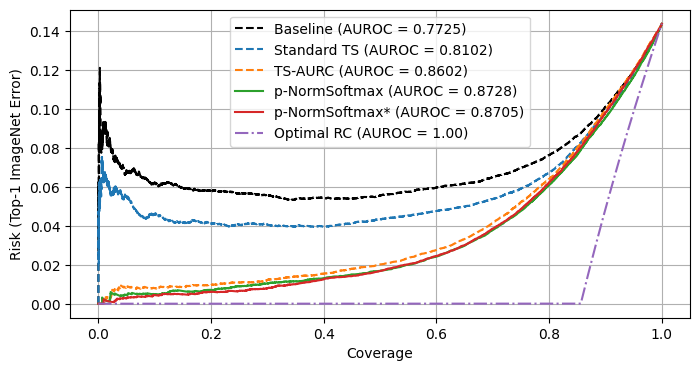

In [11]:
fig = plt.figure(figsize = (8,4))
fig.tight_layout()
auroc = metrics.AUROC(risk_test,measures.MSP(logits_test))
plt.plot(*baseline,'k--', label  = 'Baseline'+ f' (AUROC = {auroc:.4f}) ')
auroc = metrics.AUROC(risk_test,measures.MSP(logits_test.div(T_nll)))
plt.plot(*TS_nll, '--',label  = 'Standard TS'+ f' (AUROC = {auroc:.4f})')
auroc = metrics.AUROC(risk_test,measures.MSP(logits_test.div(T)))
plt.plot(*TS, '--',label  = 'TS-AURC'+ f' (AUROC = {auroc:.4f})')
auroc = metrics.AUROC(risk_test,pNormSoftmax.pNormSoftmax(logits_test,p,beta))
plt.plot(*P_opt, label  = 'p-NormSoftmax'+ f' (AUROC = {auroc:.4f})')
auroc = metrics.AUROC(risk_test,pNormSoftmax.pNormSoftmax(logits_test,pT[0],pT[1]))
plt.plot(*PT, label  = 'p-NormSoftmax*'+ f' (AUROC = {auroc:.4f})')
auroc = metrics.AUROC(risk_test,risk_test.logical_not().float())
plt.plot(*optimal,'-.', label  = 'Optimal RC'+ f' (AUROC = {auroc:.2f})')

plt.grid()
plt.legend()
plt.xlabel('Coverage')
plt.ylabel('Risk (Top-1 ImageNet Error)')
plt.savefig(os.path.join(FIGS_PATH, f'RC-{MODEL_ARC}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

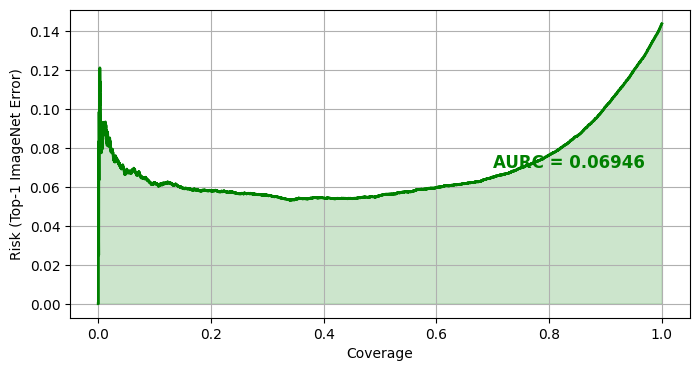

In [12]:
fig = plt.figure(figsize = (8,4))
fig.tight_layout()
aurc = metrics.AURC(risk_test,measures.MSP(logits_test))
plt.plot(*baseline,'-',linewidth = 2.0, color = 'green')
plt.fill_between(baseline[0],np.zeros_like(baseline[0]),baseline[1], color = 'green',alpha = 0.2)

plt.grid()
#plt.legend()
plt.xlabel('Coverage')
plt.ylabel('Risk (Top-1 ImageNet Error)')
plt.text(0.7,0.07,f'AURC = {aurc:.5f}',color = 'green', fontweight = 550, fontsize = 'large')
plt.savefig(os.path.join(FIGS_PATH, f'RC-{MODEL_ARC}_baseline.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

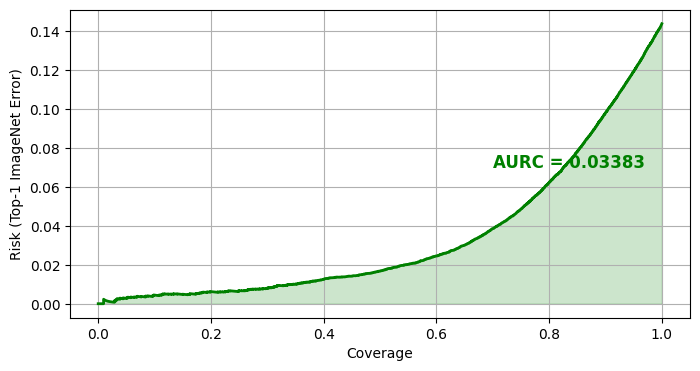

In [13]:
fig = plt.figure(figsize = (8,4))
fig.tight_layout()
aurc = metrics.AURC(risk_test,pNormSoftmax.pNormSoftmax(logits_test,pT[0],pT[1]))
plt.plot(*PT,linewidth = 2.0, color = 'green')
plt.fill_between(PT[0],np.zeros_like(PT[0]),PT[1], color = 'green',alpha = 0.2)

plt.grid()
#plt.legend()
plt.xlabel('Coverage')
plt.ylabel('Risk (Top-1 ImageNet Error)')
plt.text(0.7,0.07,f'AURC = {aurc:.5f}',color = 'green', fontweight = 550, fontsize = 'large')
#plt.savefig(os.path.join(FIGS_PATH, f'RC-{MODEL_ARC}_PT.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

In [14]:
(69.75-33.87)/69.75

0.5144086021505376

In [15]:
(69.46-33.83)/69.46

0.5129570976101353